In [1]:
import numpy as np
import pickle as pkl

import pymc3 as pm
import theano
import theano.tensor as tt

import jax.numpy as jnp
from jax import random, jit, vmap, lax
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro import optim
from numpyro.distributions import constraints
from numpyro.infer import *
numpyro.enable_x64()


%matplotlib inline
%run ../notebook_setup.py

## PyMC3 model

In [2]:
# Load data
with open('Apad.pickle', 'rb') as handle:
    Apad = pkl.load(handle)
with open('fpad.pickle', 'rb') as handle:
    fpad = pkl.load(handle)
with open('ferrpad.pickle', 'rb') as handle:
    ferrpad = pkl.load(handle)
with open('PInvT.pickle', 'rb') as handle:
    PInvT = pkl.load(handle)
    
mask = (fpad != 0).reshape(-1)

In [3]:
K = 2
L = fpad.shape[0]
npix = PInvT.shape[0]

BT_testval = 0.001*np.random.rand(K, npix)
QT_testval = 100*np.random.rand(L, K)

with pm.Model() as model:
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    BT = pm.Dirichlet("BT", a=0.8 * np.ones(npix), shape=(K, npix), testval=BT_testval)
    
    QT = PositiveNormal(
        "QT", mu=0.0, sigma=1e3, shape=(L, K), testval=np.ascontiguousarray(QT_testval, dtype=np.float64)
    )
    # Pixel basis -> Ylm basis
    BT_ylm = tt.dot(BT, PInvT)

    # NMF Y=BQ
    YT = tt.dot(QT, BT_ylm)

    # Flux
    pm.Deterministic("YT", YT)
    f = tt.batched_dot(Apad, YT)
    pm.Deterministic("f", f)
    
    pm.Normal("obs", mu=f.flatten()[mask], sd=ferrpad.reshape(-1)[mask], observed=fpad.reshape(-1)[mask])

In [4]:
%%time
with model:
    advi = pm.ADVI()
    res_pymc3 = advi.fit(n=20000, obj_optimizer=pm.adam(learning_rate=0.01))
samples_pymc3 = res_pymc3.sample(500)

Finished [100%]: Average Loss = -784.29


CPU times: user 2min 14s, sys: 2.3 s, total: 2min 16s
Wall time: 42.1 s


Text(0.5, 0, 'steps')

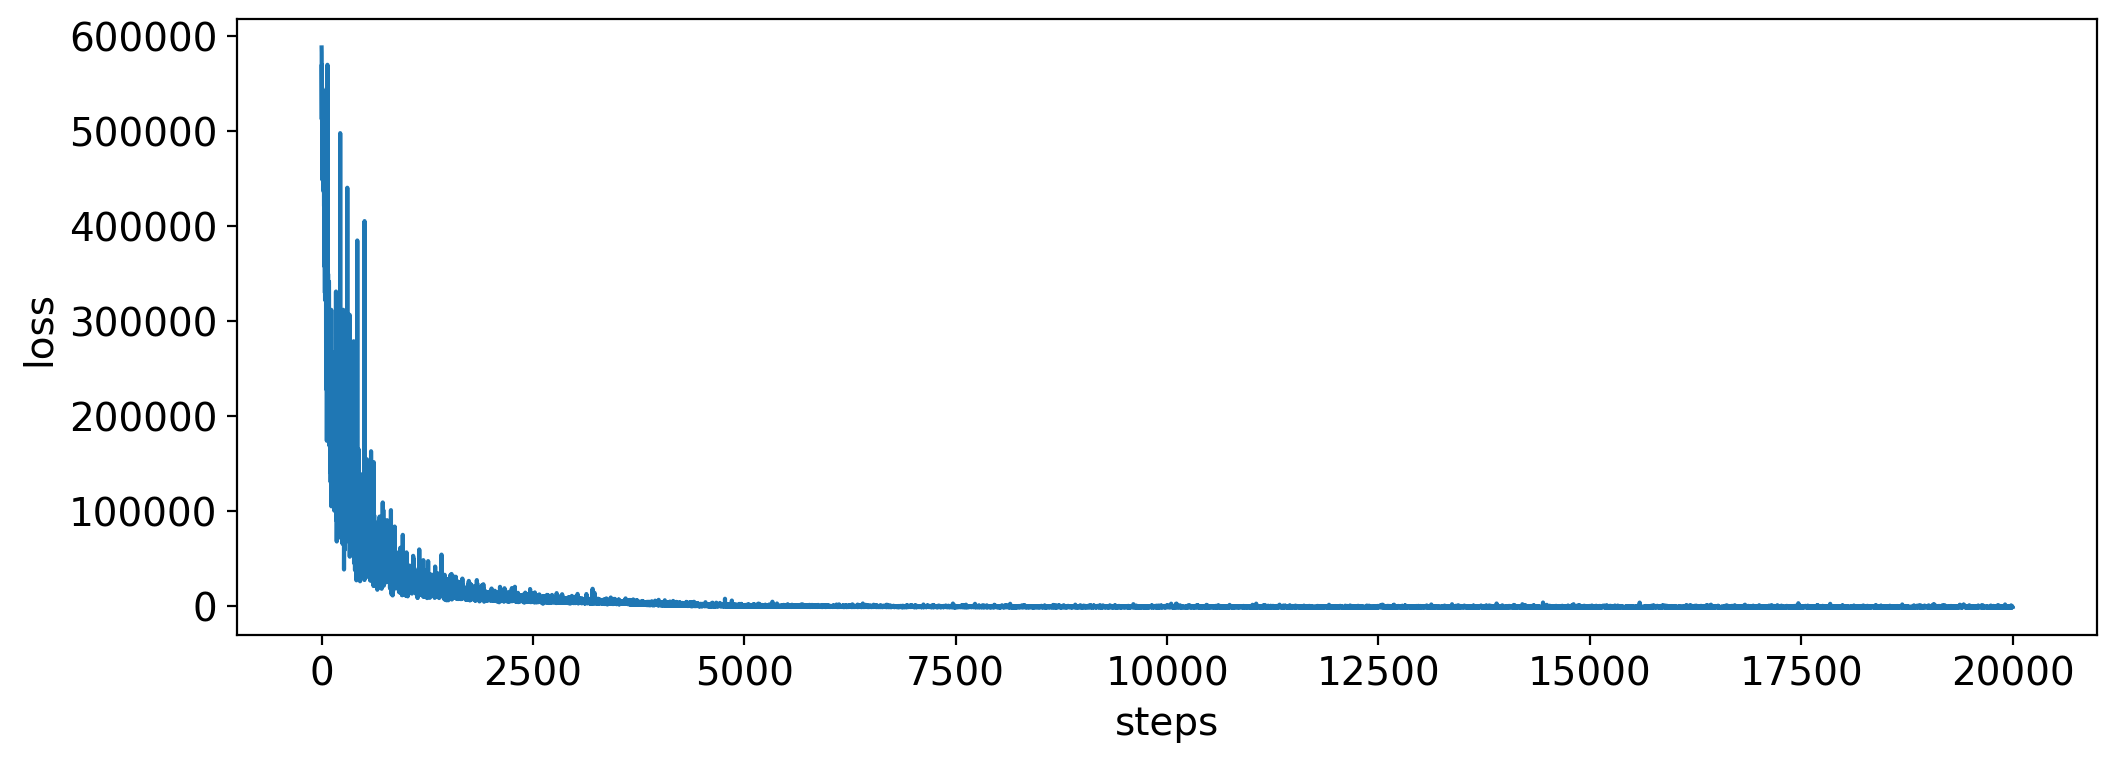

In [5]:
plt.plot(advi.hist)
plt.ylabel("loss")
plt.xlabel("steps")
# plt.yscale("log")

Residuals RMS:  0.04953227584453938


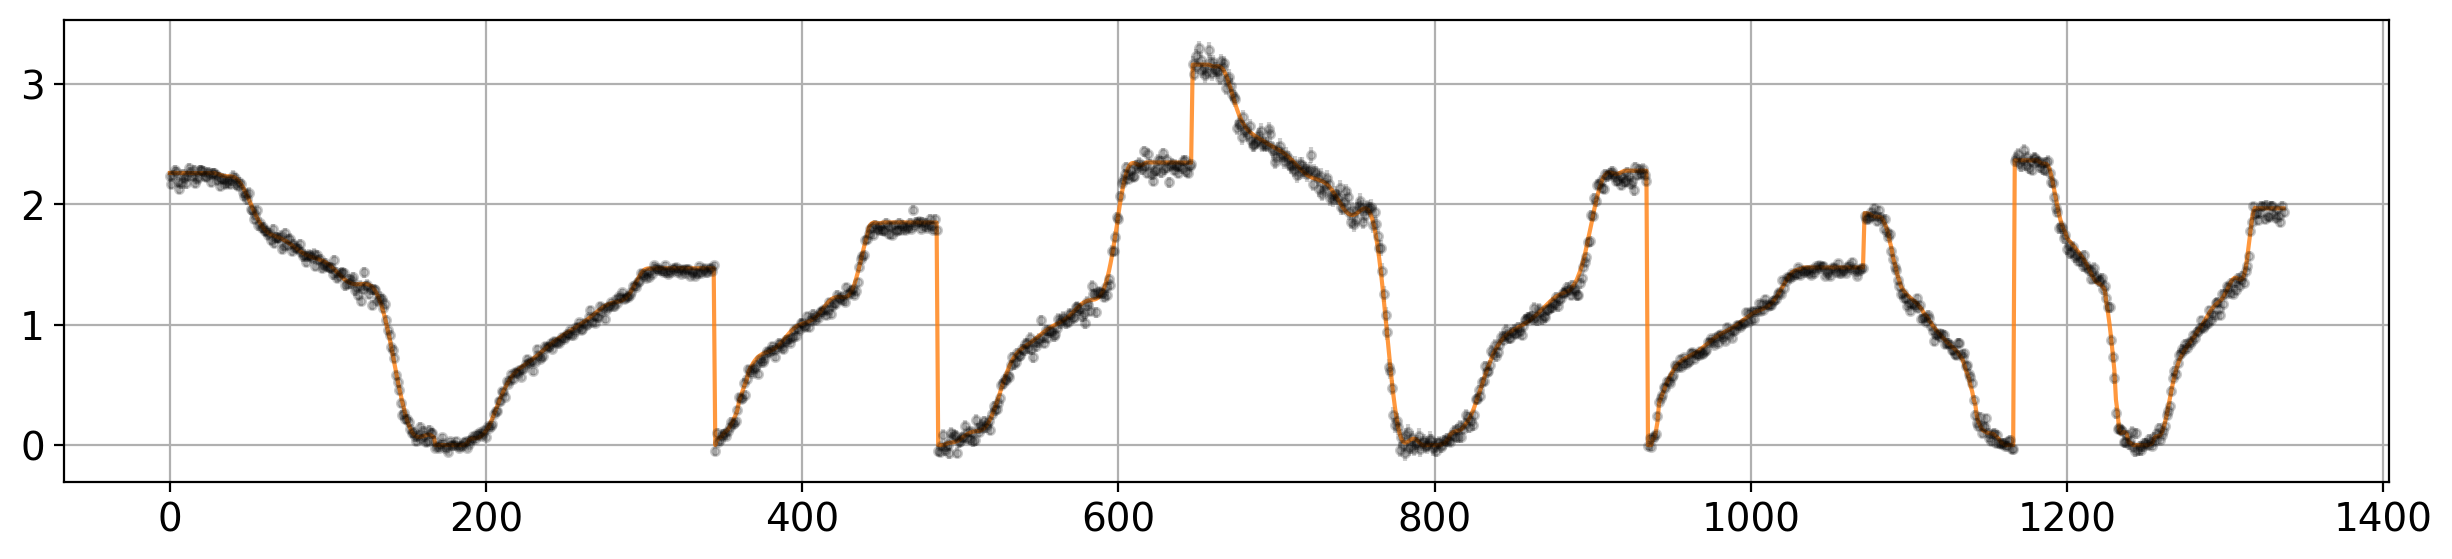

In [6]:
f_mean = np.mean(samples_pymc3['f'], axis=0).reshape(-1)[mask]
f_obs = fpad.reshape(-1)[mask]
f_err = ferrpad.reshape(-1)[mask]
res = f_obs - f_mean
res_rms = np.sqrt(np.mean(res ** 2))

print("Residuals RMS: ", res_rms)
fig, ax = plt.subplots(figsize=(15, 3))
ax.errorbar(np.arange(len(f_obs)), f_obs, f_err, color='black', fmt='.', alpha=0.2)
ax.plot(f_mean, "C1-", alpha=0.8)
ax.grid()

## Numpyro model

In [7]:
def model():
    BT = numpyro.sample("BT", dist.Dirichlet(0.8*jnp.ones((K, npix))))
    QT = numpyro.sample("QT", dist.HalfNormal(scale=1e3*jnp.ones((L, K))))
    
    # Pixel basis -> Ylm basis
    BT_ylm = BT.dot(PInvT)
    
    # NMF Y=BQ
    YT = jnp.dot(QT, BT_ylm)
    numpyro.deterministic("YT", YT)
    
    # Map columns of Y to the observables
    f = jnp.einsum('ijk,ik->ij', Apad, YT)
    numpyro.deterministic("f", f)
    numpyro.sample(f"obs", dist.Normal(f.reshape(-1)[mask], ferrpad.reshape(-1)[mask]), obs=fpad.reshape(-1)[mask])

In [8]:
init_vals = {'BT':BT_testval, 'QT':QT_testval}
guide = AutoDiagonalNormal(model, init_strategy=init_to_value(values=init_vals))
svi = SVI(model, guide, optim.Adam(0.01), Trace_ELBO())
svi_state = svi.init(random.PRNGKey(1))

In [9]:
%%time
# Train guide
last_state, losses = lax.scan(lambda state, i: svi.update(state), svi_state, jnp.zeros(20000))
params = svi.get_params(last_state)

# Convert to numpy array to avoid asynchronous dispatch in JAX
losses_np = np.array(losses)

CPU times: user 1min 10s, sys: 8.15 s, total: 1min 18s
Wall time: 37.2 s


Text(0.5, 0, 'steps')

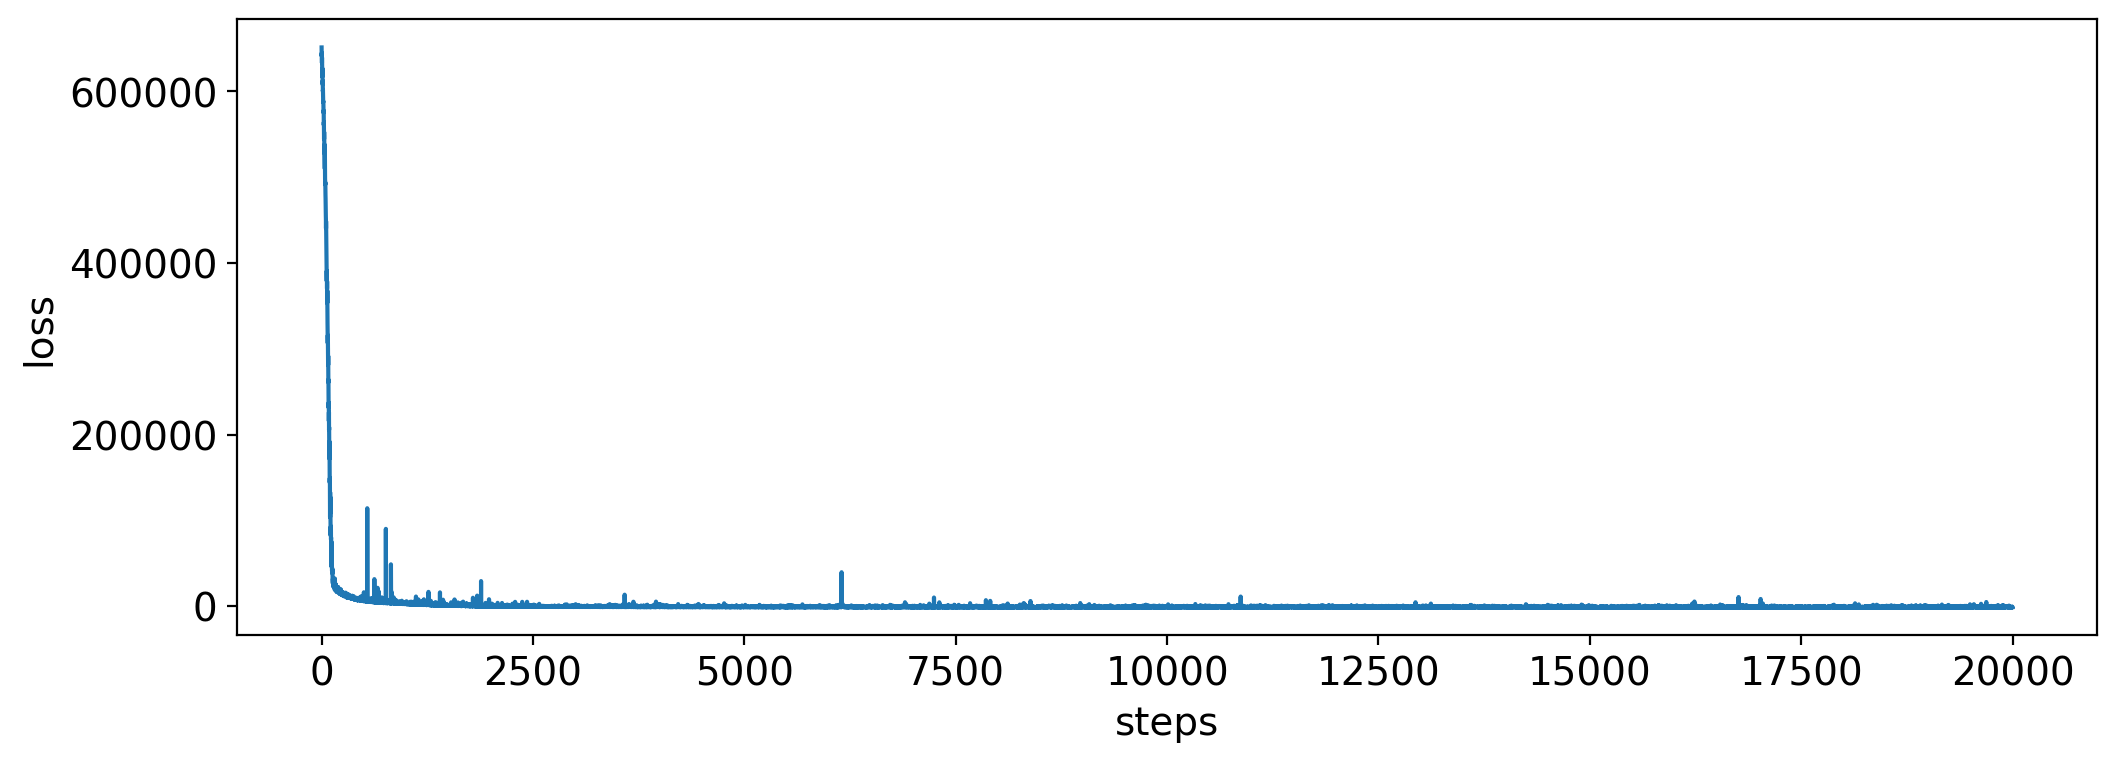

In [10]:
plt.plot(losses_np)
plt.ylabel("loss")
plt.xlabel("steps")
# plt.yscale("log")

In [11]:
predictive = Predictive(model, guide=guide, num_samples=500)
preds = predictive(random.PRNGKey(2))
samples_numpyro = {k: np.array(v) for k, v in preds.items() if k != 'obs'}

Residuals RMS:  1.3238457485610744


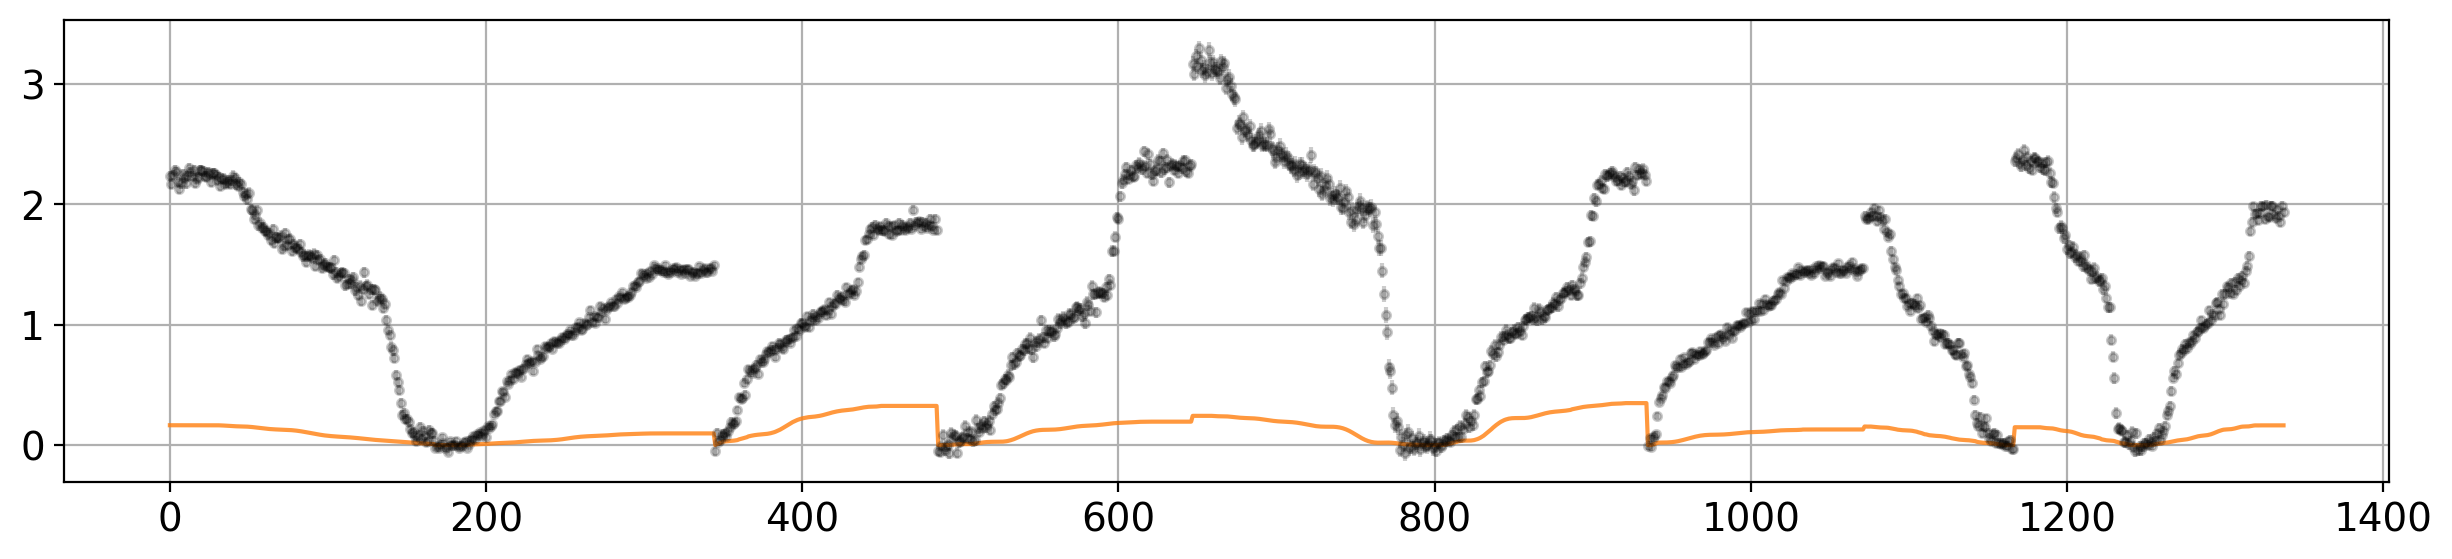

In [12]:
mask = (fpad != 0).reshape(-1)
f_mean = np.mean(samples_numpyro['f'], axis=0).reshape(-1)[mask]
f_obs = fpad.reshape(-1)[mask]
f_err = ferrpad.reshape(-1)[mask]
res = f_obs - f_mean
res_rms = np.sqrt(np.mean(res ** 2))

print("Residuals RMS: ", res_rms)
fig, ax = plt.subplots(figsize=(15, 3))
ax.errorbar(np.arange(len(f_obs)), f_obs, f_err, color='black', fmt='.', alpha=0.2)
ax.plot(f_mean, "C1-", alpha=0.8)
ax.grid()